**Algorithm**: Time Step Iteration averages of num_exp experiments on the Network

**Input**: Network Type `ER`, n=100, n_par1=.9, n_par2=10, Lambda=1.1, beta1=.8, beta2=.18, beta3=.02, alpha1=.1, alpha2=.055, delta_I=.03, delta_T=.03, mu=.01,
                          S=85, E=5, I=10, Tt=0, R=0, N=100, t=100, num_exp = 10, verbose = F

**Output**: avgs 'Average results of the num_exp experiments"

1. **For each experiment in num_exp experiments:**
    1. Create network 'g' with given parameters
    2. Assign statuses to nodes randomly with given parameters
    3. **For each time step t in the simulation:**
        1. Save the current status of each node.
        2. **For each type of removal (Infection, Treatment, natural death):**
            1. Calculate the number of nodes to remove `nodes_to_remove_count`
            2. Separate `nodes_to_remove_count` into a floor value `floor_value` and a fractional part `fractional_part`
            3. **if** `floor_value` > 0 **then**
                1. Remove `floor_value` number of nodes
            4. **if** `fractional_part` > 0 **then**
                1. Remove an additional node with a probability equal to `fractional_part`
        3. Calculate the number of nodes to add `nodes_to_add_count`
        4. Separate `nodes_to_add_count` into a floor value `floor_value` and a fractional part `fractional_part`
        5. **if** `floor_value` > 0 **then**
            1. Add `floor_value` number of nodes 
            2. Add connections to the new nodes according to Network Type
        6. **if** `fractional_part` > 0 **then**
            1. Add an additional node with a probability equal to `fractional_part`
            2. Add connections to the new nodes according to Network Type
        7. **for** each node in the graph **do**
            1. Get the current status of the node.
            2. Generate a random number `rand`
            3. If the node is Susceptible and `rand` < `beta1` * `I` / `N`, change the status to Exposed
            4. If the node is Exposed and `rand` < `beta2`, change the status to Infected
            5. If the node is Infected:
                1. Generate another random number `rand2`
                2. If `rand` < `beta3`, change the status to Recovered
                3. If `rand2` < `alpha1`, change the status to Treatment
            6. If the node is under Treatment and `rand` < `alpha2`, change the status to Recovered
        8. Count the number of nodes in each status and store these counts in `S_count`, `E_count`, `I_count`, `Tt_count`, `R_count`, `N_count`
        9. Calculate various network metrics and store these metrics in `degree_dist`, `clustering_coeff`, `avg_path_length`, `largest_comp_size`
        10. Store the experiment result
    4. Calculate and store the averages of num_exp experiments
2. Return averages


In [1]:
library(igraph)  # For network analysis and visualization
library(deSolve)  # For solving differential equations
library(ggplot2)
library(dplyr)

Warning message:
"package 'igraph' was built under R version 4.2.3"

Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Warning message:
"package 'deSolve' was built under R version 4.2.3"
Warning message:
"package 'ggplot2' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [7]:
SEITR_network <- function(network_type="ER", n=100, n_par1=.9, n_par2=10, 
                          Lambda=1.1, beta1=.8, beta2=.18, beta3=.02, alpha1=.1, alpha2=.055, delta_I=.03, delta_T=.03, mu=.01,
                          S=85, E=5, I=10, Tt=0, R=0, N=100, t=100, num_exp = 10, verbose = F) {
  times <- seq(0, t, by = 1)
  state <- c(S = S, E = E, I = I, Tt = Tt, R = R, N = N)
  parameters <- c(Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2, delta_I = delta_I, delta_T = delta_T, mu = mu)
  
  out <- ode(y = state, times = times, func = SEITR, parms = parameters)
  if(verbose){
    par(mfrow = c(3, 2))  # Set up a 3x2 grid for the plots
    plot(out[, "time"], out[, "S"], type = "l", col = 2, xlab = "Time (Days)", ylab = "Susceptibles", main = "Susceptibles")
    plot(out[, "time"], out[, "E"], type = "l", col = 3, xlab = "Time (Days)", ylab = "Exposed", main = "Exposed")
    plot(out[, "time"], out[, "I"], type = "l", col = 4, xlab = "Time (Days)", ylab = "Infected", main = "Infected")
    plot(out[, "time"], out[, "Tt"], type = "l", col = 5, xlab = "Time (Days)", ylab = "Treatment", main = "Treatment")
    plot(out[, "time"], out[, "R"], type = "l", col = 6, xlab = "Time (Days)", ylab = "Recovered", main = "Recovered")
    plot(out[, "time"], out[, "N"], type = "l", col = 7, xlab = "Time (Days)", ylab = "Total Population", main = "Total Population")
  }
  status_counts_list <- vector("list", num_exp)
  
  for (exp in 1:num_exp) {
    if(network_type == "ER"){
      init_p <- n_par1  # The probability of creating an edge between any two nodes
      g <- erdos.renyi.game(n=N, p = init_p)  # Create the graph
    } else if (network_type == "BA"){
      init_p <- N * n_par1
      g <- sample_pa(n=N, power = 1, m = init_p, directed = FALSE)
    } else if (network_type == "WS"){
      init_p <- n_par1
      k <- n_par2
      g <- sample_smallworld(dim = 1, size = N, nei = k, p = init_p)
    } else if (network_type == "LN"){
      k <- n_par1  # The number of nearest neighbors in ring topology
      g <- make_lattice(length = N, dim = 1, nei = k, directed = FALSE, mutual = TRUE, circular = TRUE)
    } else if (network_type == "RR"){
      k <- n_par1  # The number of edges to attach from each new node to existing nodes
      g <- sample_k_regular(no.of.nodes = N, k = n_par1, directed = FALSE)
    }
    
    status_counts <- list()
    V(g)$label <- 1:N  # Label the nodes with numbers from 1 to n
    V(g)$status <- "S"  # Initially, all nodes are Susceptible (S)
    V(g)$status[sample(1:n, size = I)] <- "I"
    V(g)$status[sample(setdiff(1:n, which(V(g)$status == "I")), size = E)] <- "E"
    V(g)$status[sample(setdiff(1:n, which(V(g)$status %in% c("I", "E"))), size = Tt)] <- "Tt"
    V(g)$status[sample(setdiff(1:n, which(V(g)$status %in% c("I", "E", "Tt"))), size = R)] <- "R"
    S_count <- S
    E_count <- E
    I_count <- I
    Tt_count <- Tt
    R_count <- R
    N_count <- N
    
    degree_dist <- vector("list", length(times))  # Degree distribution
    clustering_coeff <- numeric(length(times))  # Clustering coefficient
    avg_path_length <- numeric(length(times))  # Average path length
    largest_comp_size <- numeric(length(times))  # Size of the largest connected component
    
    status_colors <- c("S" = "gray", "E" = "orange", "I" = "red", "Tt" = "green", "R" = "purple", "N" = "blue")
    if(verbose){
      par(mfrow = c(1, 1))  # Set up a 1x1 grid for the plot
      plot(g, vertex.color = status_colors[V(g)$status], vertex.label = V(g)$label, vertex.size=10)
      title(paste("Initial Network"))
      status_counts_plot <- table(V(g)$status)
      status_labels <- paste(names(status_colors), " (", status_counts_plot[names(status_colors)], ")", sep = "")
      legend("bottomright", legend = status_labels, fill = status_colors, title = "Status")
    }
    node_counter <- vcount(g)  # The current number of nodes in the graph
    for (t in times) {
      old_status <- V(g)$status
      
      nodes_to_remove_count <- delta_I * sum(V(g)$status == "I")
      floor_value <- floor(nodes_to_remove_count)
      fractional_part <- nodes_to_remove_count - floor_value
      nodes_with_status_I <- which(V(g)$status == "I")
      if (floor_value > 0 && length(nodes_with_status_I) > 0){
        for (i in 1:floor_value) {
          node_to_remove <- sample(nodes_with_status_I, 1)  # Select a node to remove at random
          if(verbose){cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed due to Infection\n")}  # Print a message indicating which node was removed
          g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
        }
      }
      if (fractional_part > 0){
        if (runif(1) < fractional_part) {
          node_to_remove <- sample(nodes_with_status_I, 1)  # Select a node to remove at random
          if(verbose){cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed due to Infection\n")}  # Print a message indicating which node was removed
          g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
        }
      }
      
      nodes_to_remove_count <- delta_T * sum(V(g)$status == "Tt")
      floor_value <- floor(nodes_to_remove_count)
      fractional_part <- nodes_to_remove_count - floor_value
      nodes_with_status_T <- which(V(g)$status == "Tt")
      if (floor_value > 0){
        for (i in 1:floor_value) {
          node_to_remove <- sample(nodes_with_status_T, 1)  # Select a node to remove at random
          if(verbose){cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed during Treatment\n")}  # Print a message indicating which node was removed
          g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
        }
      }
      if (fractional_part > 0){
        if (runif(1) < fractional_part) {
          node_to_remove <- sample(nodes_with_status_T, 1)  # Select a node to remove at random
          if(verbose){cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed during Treatment\n")}  # Print a message indicating which node was removed
          g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
        }
      }
      
      nodes_to_remove_count <- mu * vcount(g)
      floor_value <- floor(nodes_to_remove_count)
      fractional_part <- nodes_to_remove_count - floor_value
      if (floor_value > 0){
        for (i in 1:floor_value) {
          node_to_remove <- sample(vcount(g), 1)  # Select a node to remove at random
          if(verbose){cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed\n")}  # Print a message indicating which node was removed
          g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
        }
      }
      if (fractional_part > 0){
        if (runif(1) < fractional_part) {
          node_to_remove <- sample(vcount(g), 1)  # Select a node to remove at random
          if(verbose){cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed\n")}  # Print a message indicating which node was removed
          g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
        }
      }
      
      nodes_to_add_count <- Lambda
      floor_value <- floor(nodes_to_add_count)
      fractional_part <- nodes_to_add_count - floor_value
      if (floor_value > 0){
        for (i in 1:floor_value) {
          node_counter <- node_counter + 1  # Increment the node counter
          new_status <- "S"  # The status of the new nodes is Susceptible (S)
          new_label <- node_counter  # The label of the new nodes is the current value of the node counter
          g <- add_vertices(g, 1)  # Add a new node to the graph
          V(g)[vcount(g)]$status <- new_status  # Assign the status to the new node
          V(g)[vcount(g)]$label <- new_label  # Assign the label to the new node
          if(network_type == "ER"){
            nodes_to_attach <- sample(V(g), size = min(round(init_p * vcount(g)), vcount(g) - 1))
            for (node_to_attach in nodes_to_attach) {
              if (V(g)[node_to_attach]$label != new_label) { # No self edges
                g <- add_edges(g, c(vcount(g), node_to_attach))  # Add an edge from the new node to the selected node
              }
            }
          } else if(network_type == "BA"){
            degree <- degree(g, mode = "all")
            prob <- degree / sum(degree)
            nodes_to_attach <- sample(V(g), size = min(round(mean(degree)), vcount(g)), prob = prob)
            for (node_to_attach in nodes_to_attach) {
              if (V(g)[node_to_attach]$label != new_label) {
                g <- add_edges(g, c(vcount(g), node_to_attach))
              }
            }
          } else if(network_type == "WS"){
            paths <- shortest.paths(g, v = vcount(g))
            nearest_neighbors <- order(paths)[2:(k+1)] # Exclude the new node itself
            g <- add_edges(g, c(rbind(rep(vcount(g), k), nearest_neighbors)))
            for (neighbor in nearest_neighbors) {
              if (runif(1) < init_p) {
                possible_nodes <- setdiff(V(g), c(vcount(g), neighbors(g, vcount(g))))
                new_neighbor <- sample(possible_nodes, 1)
                edge_id <- get.edge.ids(g, c(vcount(g), neighbor))
                if (!is.na(edge_id)) { # Check if the edge exists
                  g <- delete_edges(g, edge_id)
                }
                g <- add_edges(g, c(vcount(g), new_neighbor))
              }
            }
          } else if(network_type == "LN"){
            # For a lattice, connect the new node to its k nearest neighbors
            nodes_to_attach <- c((vcount(g) - n_par1 + 1):vcount(g))
            nodes_to_attach <- nodes_to_attach[nodes_to_attach > 0 & nodes_to_attach < vcount(g)]
            g <- add_edges(g, c(rbind(rep(vcount(g), length(nodes_to_attach)), nodes_to_attach)))
          } else if (network_type == "RR"){
            nodes_to_attach <- sample(V(g)[-vcount(g)], size = n_par1)
            g <- add_edges(g, c(rbind(rep(vcount(g), length(nodes_to_attach)), nodes_to_attach)))
          }
          if(verbose){cat("Time", t, ": New node", new_label, "added with status", new_status, "\n")}
        }
      }
      if (fractional_part > 0){
        if (runif(1) < fractional_part) {
          node_counter <- node_counter + 1  # Increment the node counter
          new_status <- "S"  # The status of the new node is Susceptible (S)
          new_label <- node_counter  # The label of the new node is the current value of the node counter
          g <- add_vertices(g, 1)  # Add a new node to the graph
          V(g)[vcount(g)]$status <- new_status  # Assign the status to the new node
          V(g)[vcount(g)]$label <- new_label  # Assign the label to the new node
          if(network_type == "ER"){
            nodes_to_attach <- sample(V(g), size = min(round(init_p * vcount(g)), vcount(g) - 1))
            for (node_to_attach in nodes_to_attach) {
              if (V(g)[node_to_attach]$label != new_label) { # No self edges
                g <- add_edges(g, c(vcount(g), node_to_attach))  # Add an edge from the new node to the selected node
              }
            }
          } else if(network_type == "BA"){
            degree <- degree(g, mode = "all")
            prob <- degree / sum(degree)
            nodes_to_attach <- sample(V(g), size = min(round(mean(degree)), vcount(g)), prob = prob)
            for (node_to_attach in nodes_to_attach) {
              if (V(g)[node_to_attach]$label != new_label) {
                g <- add_edges(g, c(vcount(g), node_to_attach))
              }
            }
          } else if(network_type == "WS"){
            paths <- shortest.paths(g, v = vcount(g))
            nearest_neighbors <- order(paths)[2:(k+1)] # Exclude the new node itself
            g <- add_edges(g, c(rbind(rep(vcount(g), k), nearest_neighbors)))
            for (neighbor in nearest_neighbors) {
              if (runif(1) < init_p) {
                possible_nodes <- setdiff(V(g), c(vcount(g), neighbors(g, vcount(g))))
                new_neighbor <- sample(possible_nodes, 1)
                edge_id <- get.edge.ids(g, c(vcount(g), neighbor))
                if (!is.na(edge_id)) { # Check if the edge exists
                  g <- delete_edges(g, edge_id)
                }
                g <- add_edges(g, c(vcount(g), new_neighbor))
              }
            }
          } else if(network_type == "LN"){
            # For a lattice, connect the new node to its k nearest neighbors
            nodes_to_attach <- c((vcount(g) - n_par1 + 1):vcount(g))
            nodes_to_attach <- nodes_to_attach[nodes_to_attach > 0 & nodes_to_attach < vcount(g)]
            g <- add_edges(g, c(rbind(rep(vcount(g), length(nodes_to_attach)), nodes_to_attach)))
          } else if (network_type == "RR"){
            nodes_to_attach <- sample(V(g)[-vcount(g)], size = n_par1)
            g <- add_edges(g, c(rbind(rep(vcount(g), length(nodes_to_attach)), nodes_to_attach)))
          }
          if(verbose){cat("Time", t, ": New node", new_label, "added with status", new_status, "\n")}
        }
      }
      
      for (i in V(g)) {
        status <- V(g)[i]$status
        rand <- runif(1)
        if (status == "S") {
          if (rand < beta1 * I / N) {
            V(g)[i]$status <- "E"
            if(verbose){cat("Time", t, ": Node", V(g)[i]$label, "changed status from S to E\n")}
          }
        } else if (status == "E" && rand < beta2) {
          V(g)[i]$status <- "I"
          if(verbose){cat("Time", t, ": Node", V(g)[i]$label, "changed status from E to I\n")}
        } else if (status == "I") {
          rand2 <- runif(1)
          if (rand < beta3) {
            V(g)[i]$status <- "R"
            if(verbose){cat("Time", t, ": Node", V(g)[i]$label, "changed status from I to R\n")}
          } else if (rand2 < alpha1) {
            V(g)[i]$status <- "Tt"
            if(verbose){cat("Time", t, ": Node", V(g)[i]$label, "changed status from I to Tt\n")}
          }
        } else if (status == "Tt" && rand < alpha2) {
          V(g)[i]$status <- "R"
          if(verbose){cat("Time", t, ": Node", V(g)[i]$label, "changed status from Tt to R\n")}
        }
      }
      
      S_count <- sum(V(g)$status == "S")
      I_count <- sum(V(g)$status == "I")
      E_count <- sum(V(g)$status == "E")
      Tt_count <- sum(V(g)$status == "Tt")
      R_count <- sum(V(g)$status == "R")
      N_count <- vcount(g)
      status_counts[[as.character(t)]] <- c(S_count, I_count, E_count, Tt_count, R_count, N_count)
      
      degree_dist[[t+1]] <- degree_distribution(g)  # Degree distribution
      clustering_coeff[t+1] <- transitivity(g, type = "global")  # Clustering coefficient
      avg_path_length[t+1] <- mean_distance(g, directed = FALSE)  # Average path length
      comps <- components(g)  # Connected components
      largest_comp_size[t+1] <- max(comps$csize)  # Size of the largest connected component
      
      if (t %% 10 == 0 && verbose) {
        plot(g, vertex.color = status_colors[V(g)$status], vertex.size=10, vertex.label=V(g)$label)
        title(paste("Time Step:", t))
        status_counts_plot <- table(V(g)$status)
        status_labels <- paste(names(status_colors), " (", status_counts_plot[names(status_colors)], ")", sep = "")
        legend("bottomright", legend = status_labels, fill = status_colors, title = "Status")
      }
    }
    
    if(verbose){
      #par(mfrow = c(3, 2))
      #plot(out[, "time"], out[, "S"], type = "l", col = status_colors["S"], xlab = "Time (Days)", ylab = "Susceptibles", main = "Comparison of Susceptibles")
      #lines(times, S_count, col = status_colors["S"])
      #plot(out[, "time"], out[, "E"], type = "l", col = "orange", xlab = "Time (Days)", ylab = "Exposed", main = "Comparison of Exposed")
      #lines(times, E_count, col = "orange")
      #plot(out[, "time"], out[, "I"], type = "l", col = status_colors["I"], xlab = "Time (Days)", ylab = "Infected", main = "Comparison of Infected")
      #lines(times, I_count, col = status_colors["I"])
      #plot(out[, "time"], out[, "Tt"], type = "l", col = status_colors["Tt"], xlab = "Time (Days)", ylab = "Treatment", main = "Comparison of Treatment")
      #lines(times, Tt_count, col = status_colors["Tt"])
      #plot(out[, "time"], out[, "R"], type = "l", col = status_colors["R"], xlab = "Time (Days)", ylab = "Recovered", main = "Comparison of Recovered")
      #lines(times, R_count, col = status_colors["R"])
      #plot(out[, "time"], out[, "N"], type = "l", col = "blue", xlab = "Time (Days)", ylab = "Total Population", main = "Comparison of Total Population")
      #lines(times, N_count, col = "blue")
    
    
      par(mfrow = c(2, 2))
      plot(degree_dist[[t+1]], main = paste("Degree Distribution at Time", t), xlab = "Degree", ylab = "Frequency")
      plot(times, clustering_coeff, type = "l", xlab = "Time (Days)", ylab = "Clustering Coefficient", main = "Clustering Coefficient")
      plot(times, avg_path_length, type = "l", xlab = "Time (Days)", ylab = "Average Path Length", main = "Average Path Length")
      plot(times, largest_comp_size, type = "l", xlab = "Time (Days)", ylab = "Size of Largest Component", main = "Size of Largest Component")
    
    
      df_ode <- data.frame(time = out[, "time"], S = out[, "S"], E = out[, "E"], I = out[, "I"], 
                           Tt = out[, "Tt"], R = out[, "R"], N = out[, "N"], type = "ODE")
      df_net <- data.frame(time = times, S = S_count, E = E_count, I = I_count, Tt = Tt_count, 
                           R = R_count, N = N_count, type = "Network")
      df <- rbind(df_ode, df_net)
      df_long <- tidyr::pivot_longer(df, -c(time, type), names_to = "status", values_to = "count")
      peaks <- df_long %>%
        group_by(status, type) %>%
        slice(which.max(count)) %>%
        ungroup() %>%
        mutate(label = paste0("(", round(time, 1), ", ", round(count, 1), ")"))
      network_colors <- c("S" = "gray", "E" = "orange", "I" = "red", "Tt" = "green", "R" = "purple", "N" = "blue")
      
      ggplot(df_long, aes(x = time, y = count)) +
        geom_line(data = df_long[df_long$type == "ODE", ], aes(color = type)) +
        geom_line(data = df_long[df_long$type == "Network", ], aes(color = status), linewidth = 1.1) +
        geom_point(data = peaks, aes(fill = type, color = NULL), size = 3, shape = 21) +
        geom_text(data = peaks, aes(label = label), vjust = -1) +
        scale_color_manual(values = c("ODE" = "black", network_colors)) +
        scale_fill_manual(values = c("ODE" = "white", "Network" = network_colors), guide = "none") +
        labs(x = "Time", y = "Count") +
        facet_wrap(~ factor(status, levels = c("S", "E", "I", "Tt", "R", "N")), scales = "free_y", ncol = 2) +
        theme_minimal() +
        expand_limits(y = max(df_long$count) * .4) # Expand y-axis limits
    }
    status_counts_list[[exp]] <- status_counts
  }
  par(mfrow = c(3, 2))
  statuses <- c("S", "E", "I", "Tt", "R", "N")
  colors <- c("gray", "orange", "red", "green", "purple", "blue")
  colors_alpha <- sapply(colors, function(col) rgb(red = col2rgb(col)[1,]/255, green = col2rgb(col)[2,]/255, blue = col2rgb(col)[3,]/255, alpha = 0.2)) # make the shade lighter
  avgs <- list()
  for (j in 1:length(statuses)) {
    status_counts <- status_counts_list[[1]]
    counts <- numeric(length = length(times))
    for (t in times) {
      counts[as.numeric(t)] <- status_counts[[as.character(t)]][j]
    }
    min_values <- counts[-length(counts)]  # Exclude the last element
    max_values <- counts[-length(counts)]  # Exclude the last element
    sum_values <- counts[-length(counts)]  # Exclude the last element
    count_values <- rep(1, length(times)-1)  # Adjust the length
    for (i in 2:length(status_counts_list)) {
      status_counts <- status_counts_list[[i]]
      counts <- numeric(length = length(times))
      for (t in times) {
        counts[as.numeric(t+1)] <- status_counts[[as.character(t)]][j]
      }
      min_values <- pmin(min_values, counts[-length(counts)])  # Exclude the last element
      max_values <- pmax(max_values, counts[-length(counts)])  # Exclude the last element
      sum_values <- sum_values + counts[-length(counts)]  # Exclude the last element
      count_values <- count_values + 1
    }
    avg_values <- sum_values / count_values
    avgs[[j]] <- avg_values
    highest_peak <- which.max(avg_values)
    lowest_peak <- which.min(avg_values)
    y_range <- range(c(min_values, max_values, out[-nrow(out), statuses[j]]))  # Exclude the last row
    y_margin <- (y_range[2] - y_range[1]) * 0.1
    plot(out[-nrow(out), "time"], out[-nrow(out), statuses[j]], type = "n", xlab = "Time", ylab = statuses[j], main = paste("Comparison of", statuses[j]), ylim = y_range + c(-y_margin, y_margin))  # Exclude the last row
    x <- c(times[-length(times)], rev(times[-length(times)]))  # Exclude the last element
    y <- c(min_values, rev(max_values))
    polygon(x, y, col = colors_alpha[j], border = NA)
    lines(times[-length(times)], avg_values, col = colors[j], lwd = 1)  # Exclude the last element
    lines(times[-length(times)], out[-nrow(out), statuses[j]], col = colors[j], lwd = 2)  # Exclude the last row
    points(times[highest_peak], avg_values[highest_peak], pch = 19, col = colors[j])
    text(times[highest_peak], avg_values[highest_peak], labels = paste("(", round(times[highest_peak], 1), ", ", round(avg_values[highest_peak], 1), ")", sep = ""), pos = 3, col = "black")
    points(times[lowest_peak], avg_values[lowest_peak], pch = 19, col = colors[j])
    text(times[lowest_peak], avg_values[lowest_peak], labels = paste("(", round(times[lowest_peak], 1), ", ", round(avg_values[lowest_peak], 1), ")", sep = ""), pos = 3, col = "black")
  }
  return(avgs)
}

In [3]:
state <- c(S = 85, E = 5, I = 10, Tt = 0, R = 0, N = 100)
parameters <- c(Lambda = 1.1, beta1 = .8, beta2 = .18, beta3 = .02, alpha1 = .1, alpha2 = .055, delta_I = .03, delta_T = .03, mu = .01)
times <- seq(0, 100, by = 1)
out <- ode(y = state, times = times, func = SEITR, parms = parameters)

compare_experiment_sets <- function(experiment_sets_list) {
  experiment_names <- sapply(as.list(substitute(experiment_sets_list))[-1], deparse)
  par(mfrow = c(1, 1))
  statuses <- c("S", "E", "I", "Tt", "R", "N")
  colors <- rainbow(length(experiment_sets_list))
  times <- seq(0, 100, by = 1)
  for (j in 1:length(statuses)) {
    y_range <- range(c(out[-nrow(out), statuses[j]]))  # Exclude the last row
    plot(out[-nrow(out), "time"], out[-nrow(out), statuses[j]], type = "n", xlab = "Time", ylab = statuses[j], main = paste("Comparison of", statuses[j]), ylim = y_range + c(-5, 5))  # Exclude the last row
    lines(times[-length(times)], out[-nrow(out), statuses[j]], col = "black", lwd = 2)
    cnt <- 1
    for (experiment_set in experiment_sets_list) {
      avg_values <- experiment_set[[j]]
      highest_peak <- which.max(avg_values)
      lowest_peak <- which.min(avg_values)
      lines(times[-length(times)], avg_values, col = colors[cnt], lwd = 1)
      points(times[highest_peak], avg_values[highest_peak], pch = 19, col = colors[cnt])
      text(times[highest_peak], avg_values[highest_peak], labels = paste("(", round(times[highest_peak], 1), ", ", round(avg_values[highest_peak], 1), ")", sep = ""), pos = 3, col = "black")
      points(times[lowest_peak], avg_values[lowest_peak], pch = 19, col = colors[cnt])
      text(times[lowest_peak], avg_values[lowest_peak], labels = paste("(", round(times[lowest_peak], 1), ", ", round(avg_values[lowest_peak], 1), ")", sep = ""), pos = 3, col = "black")
      cnt <- cnt + 1
    }
    if(j == 5){legend("bottomright", legend = c("ODE", experiment_names), fill = c("black", colors), bty = "n")}
    else{legend("topright", legend = c("ODE", experiment_names), fill = c("black", colors), bty = "n")}
  }
}

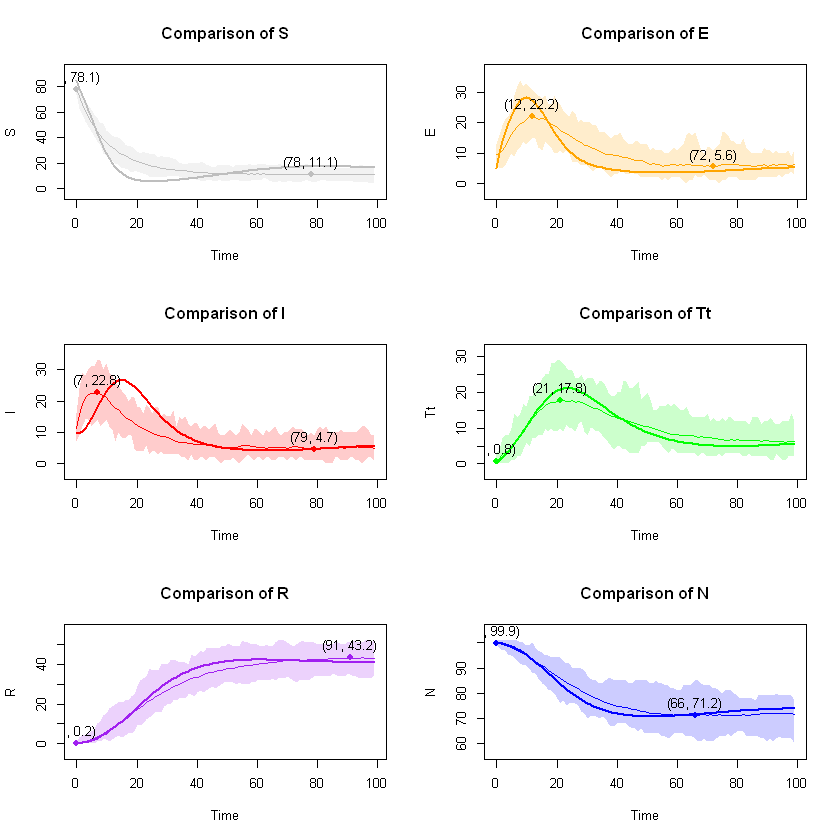

In [4]:
ws_p.1_k20 <- SEITR_network("WS", n_par1=0.1, n_par2=20, num_exp = 50)

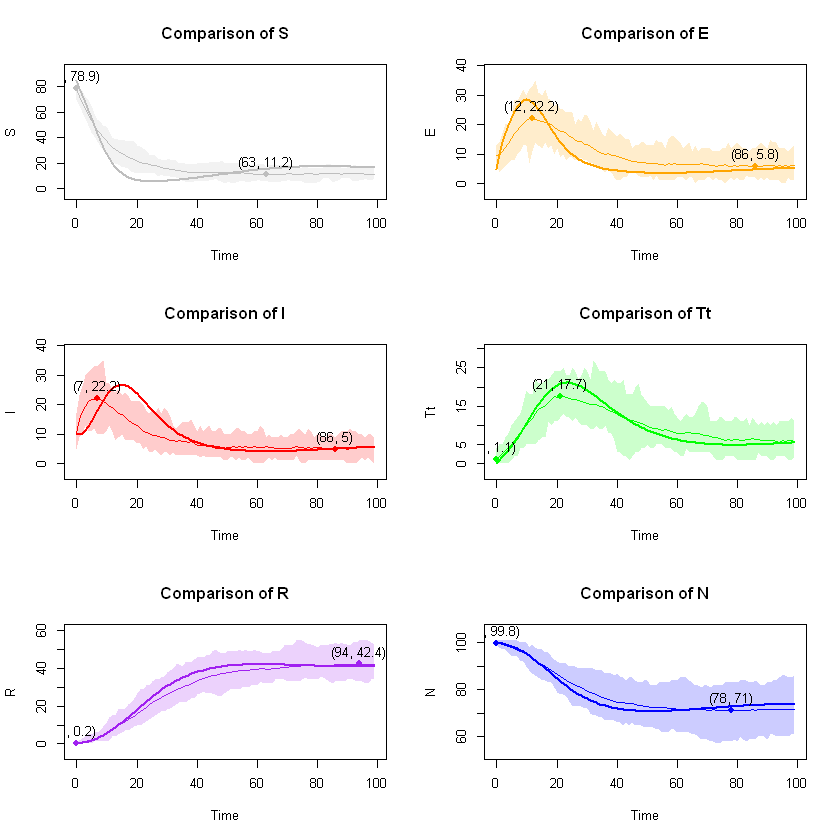

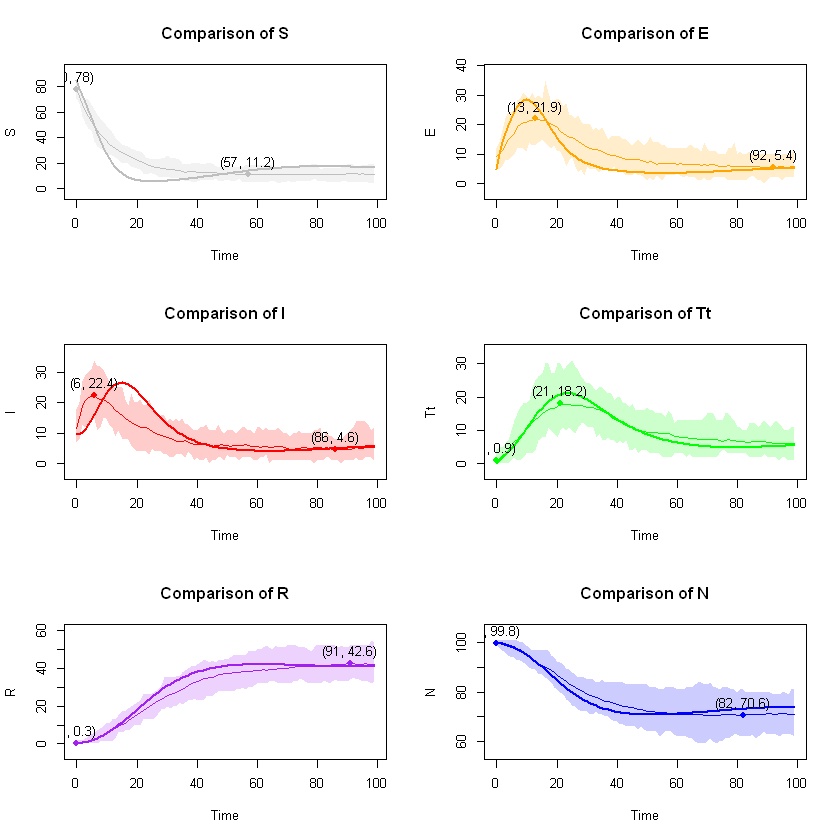

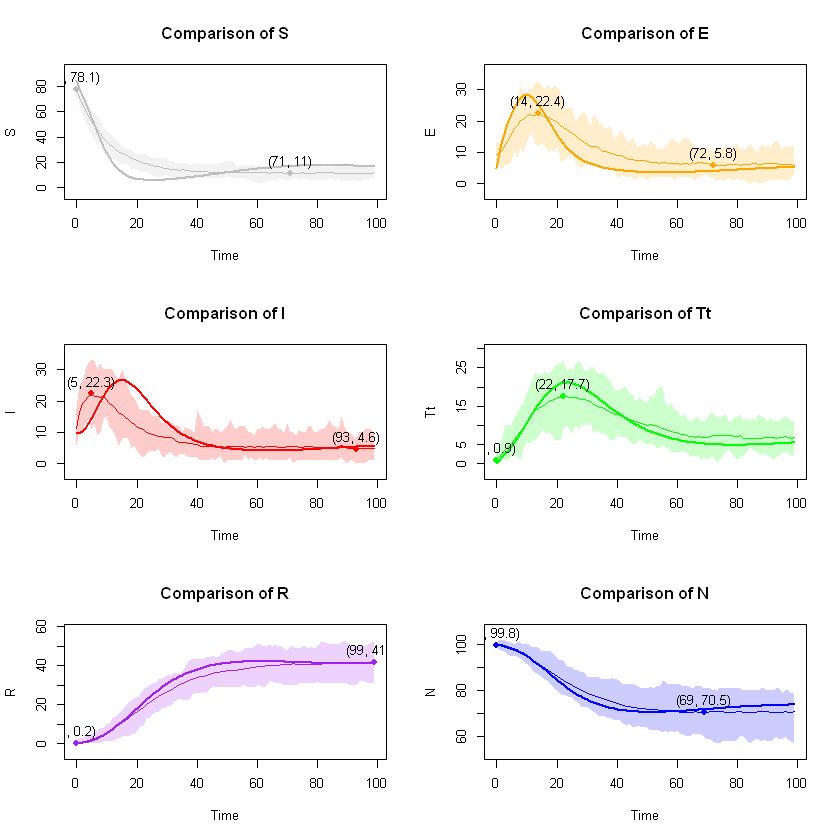

In [15]:
ws_p.3_k20 <- SEITR_network("WS", n_par1=0.3, n_par2=20, num_exp = 50)
ws_p.5_k20 <- SEITR_network("WS", n_par1=0.5, n_par2=20, num_exp = 50)
ws_p.9_k20 <- SEITR_network("WS", n_par1=0.9, n_par2=20, num_exp = 50)

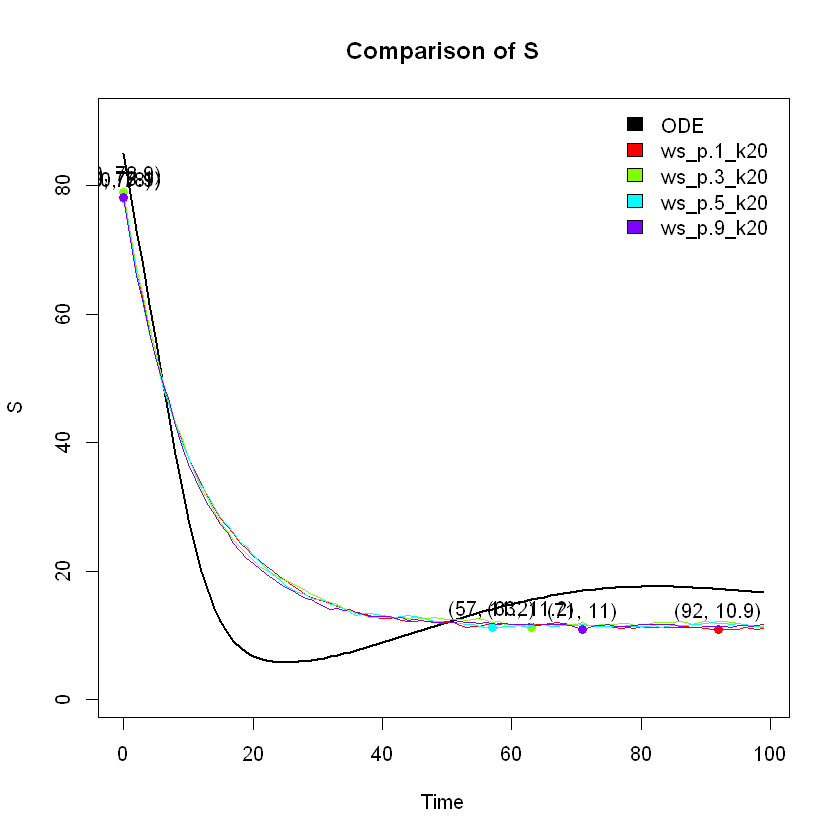

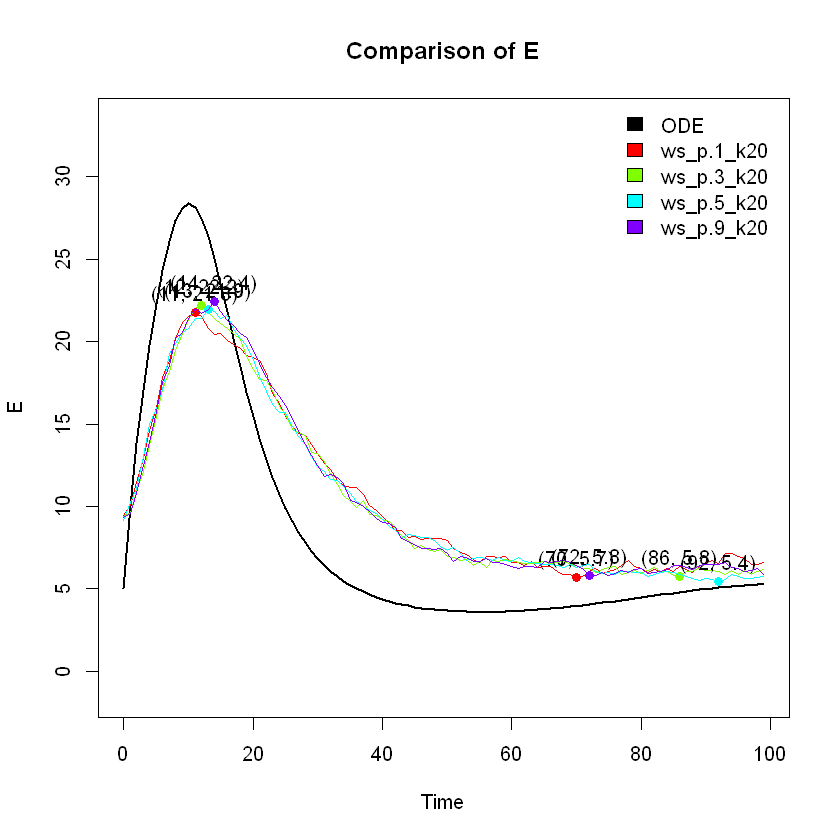

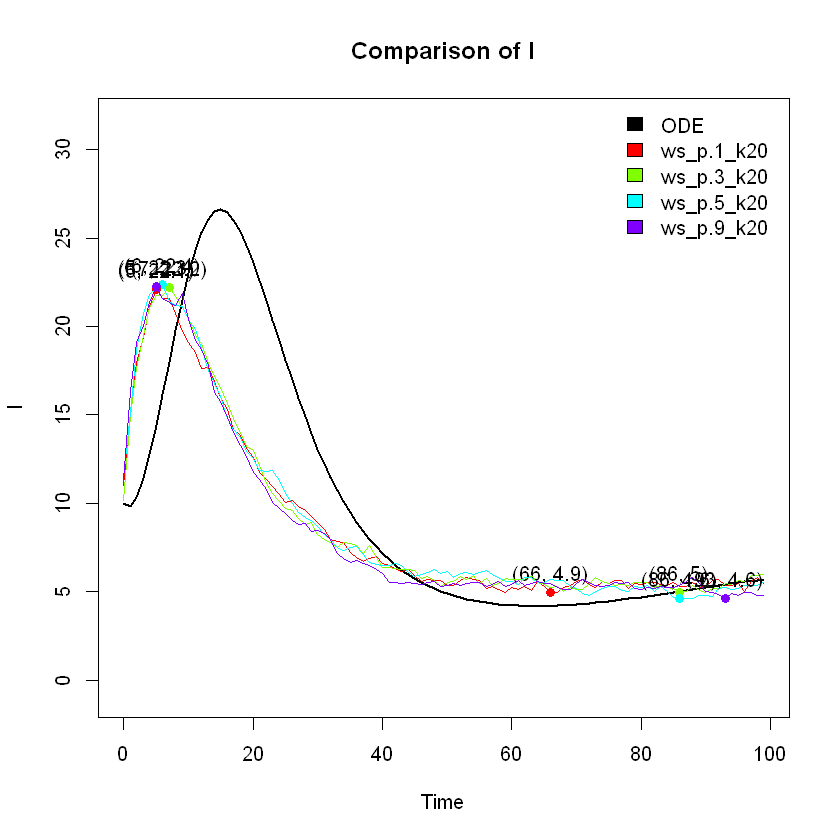

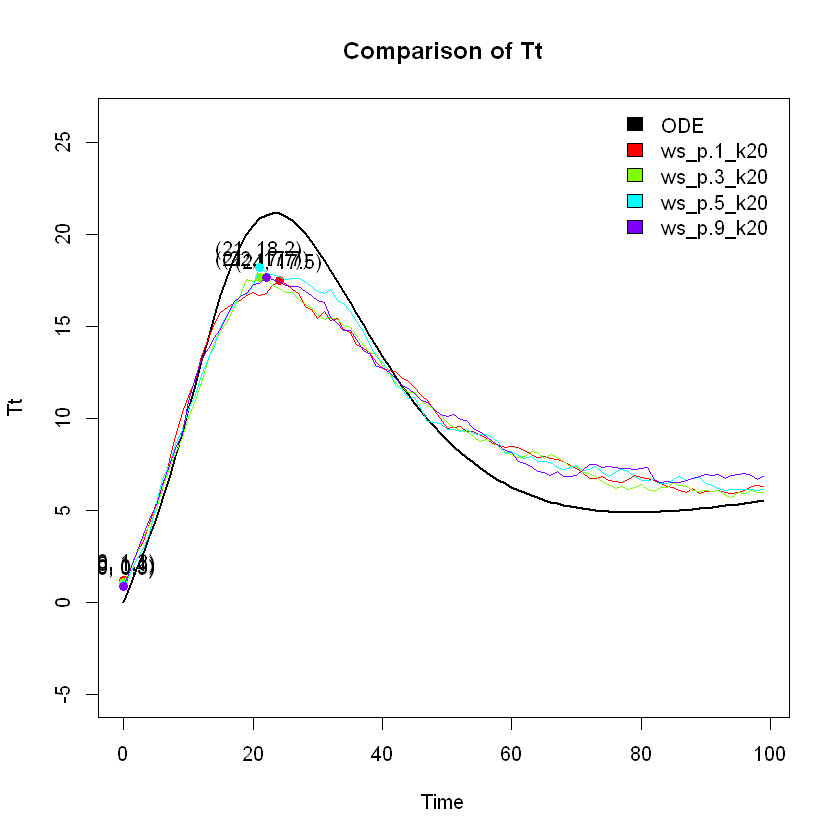

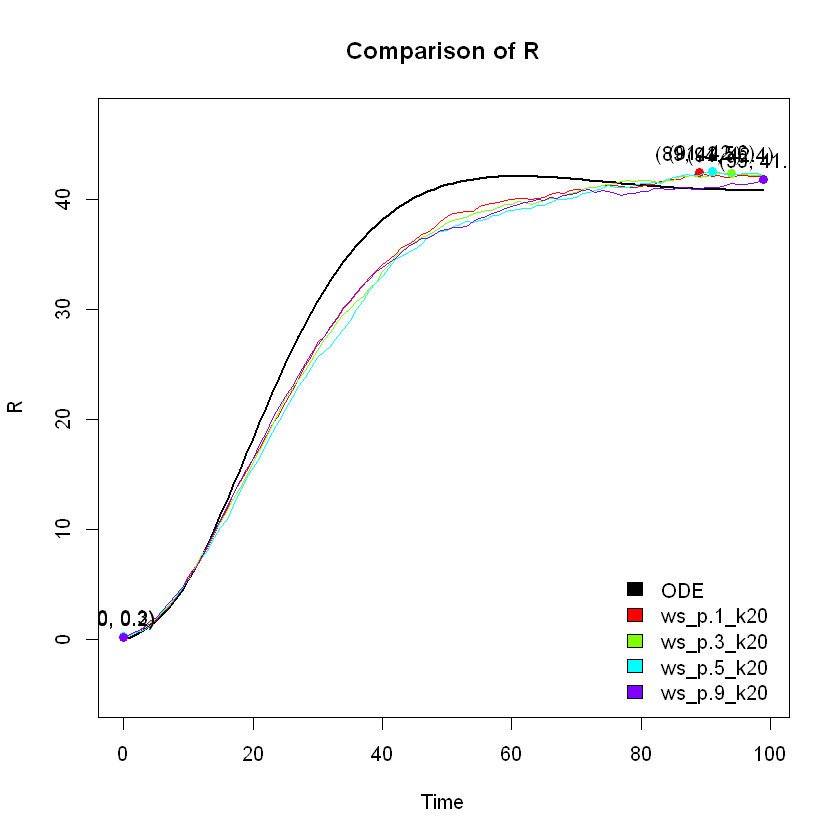

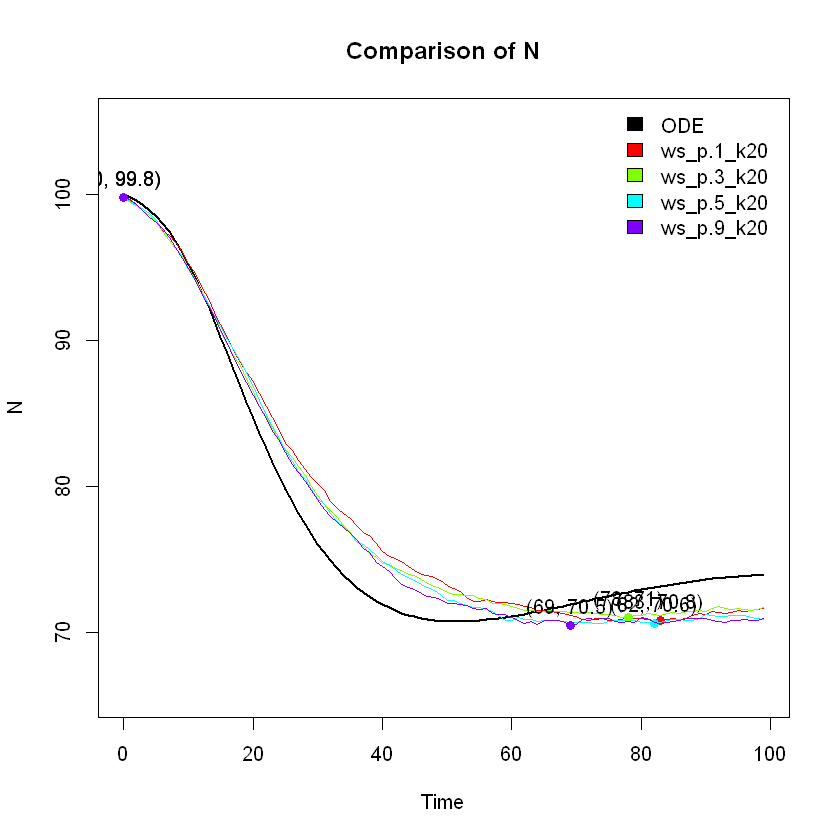

In [16]:
compare_experiment_sets(list(ws_p.1_k20, ws_p.3_k20, ws_p.5_k20, ws_p.9_k20))

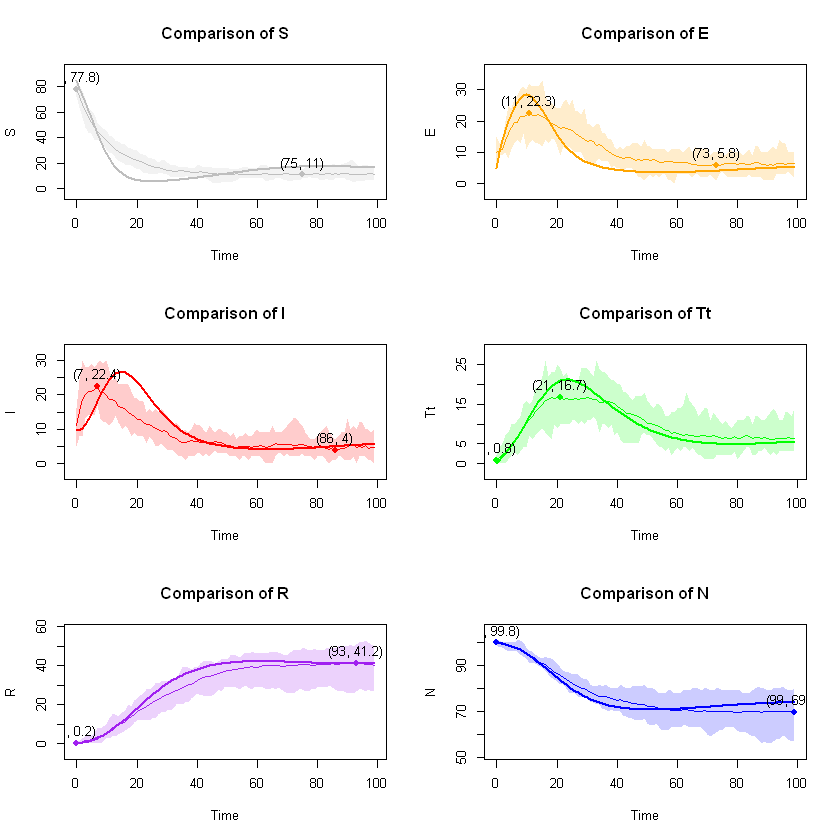

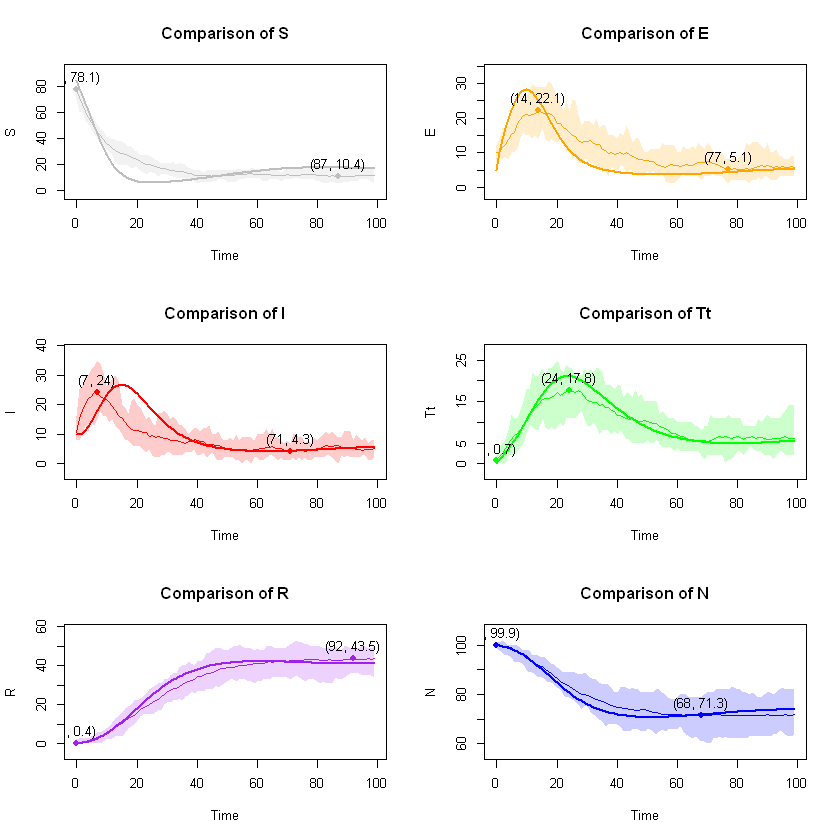

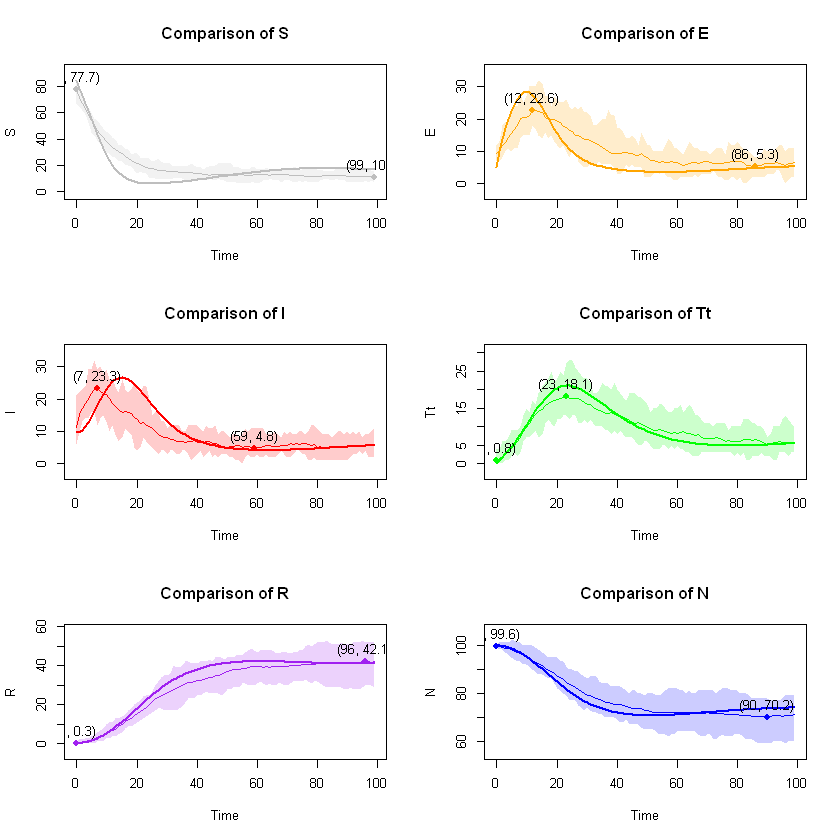

In [17]:
er_p.3 <- SEITR_network("ER", n_par1=0.3, num_exp = 20)
ba_p.3 <- SEITR_network("BA", n_par1=0.3, num_exp = 20)
ws_p.3_k20 <- SEITR_network("WS", n_par1=0.3, n_par2=20, num_exp = 20)

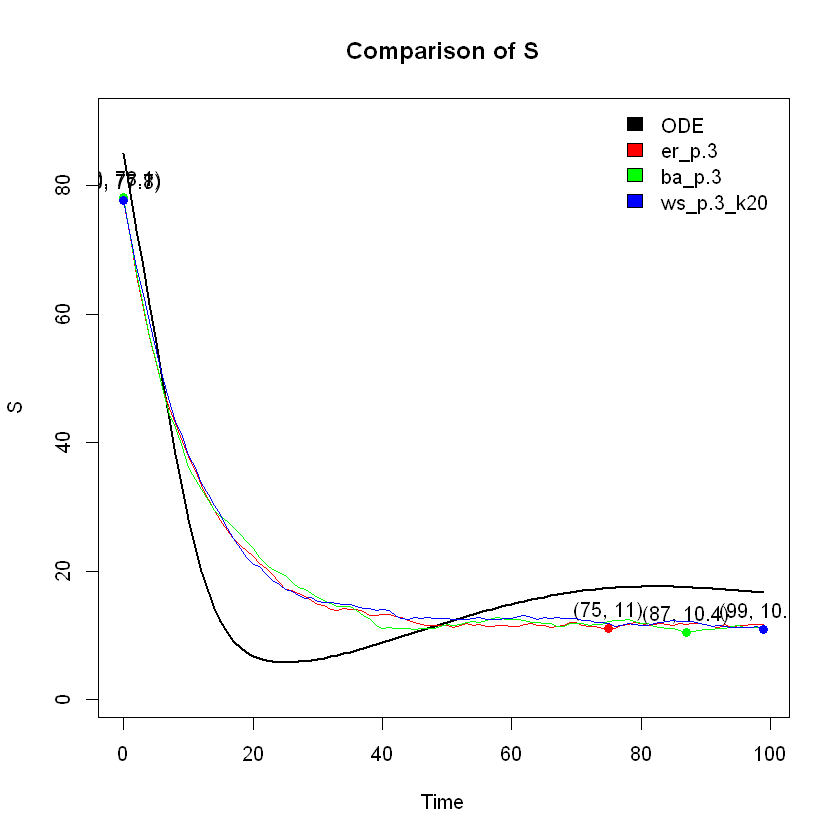

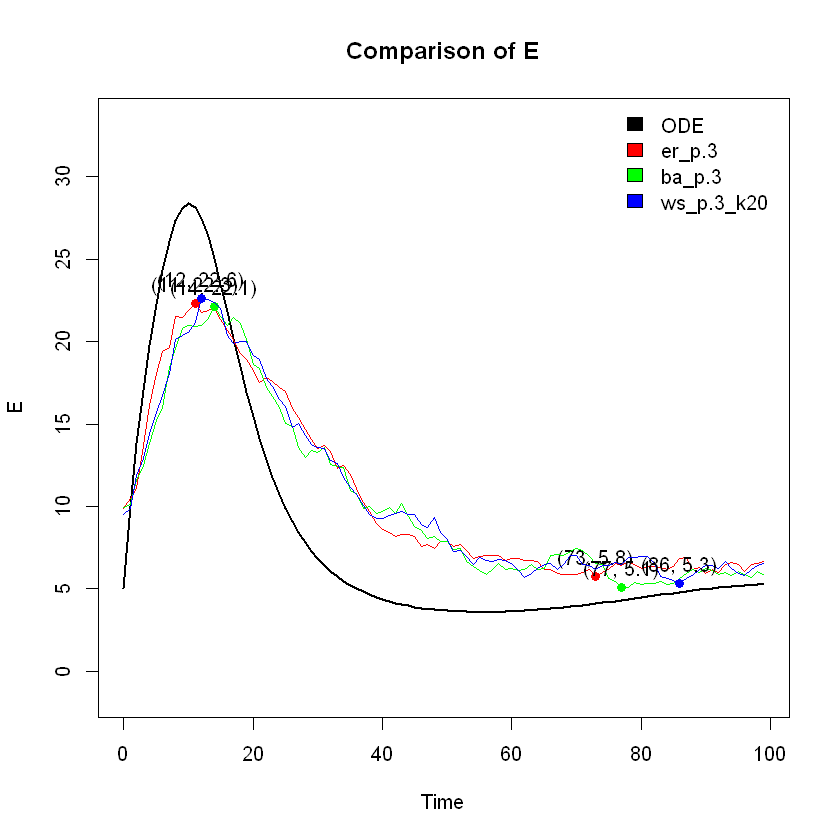

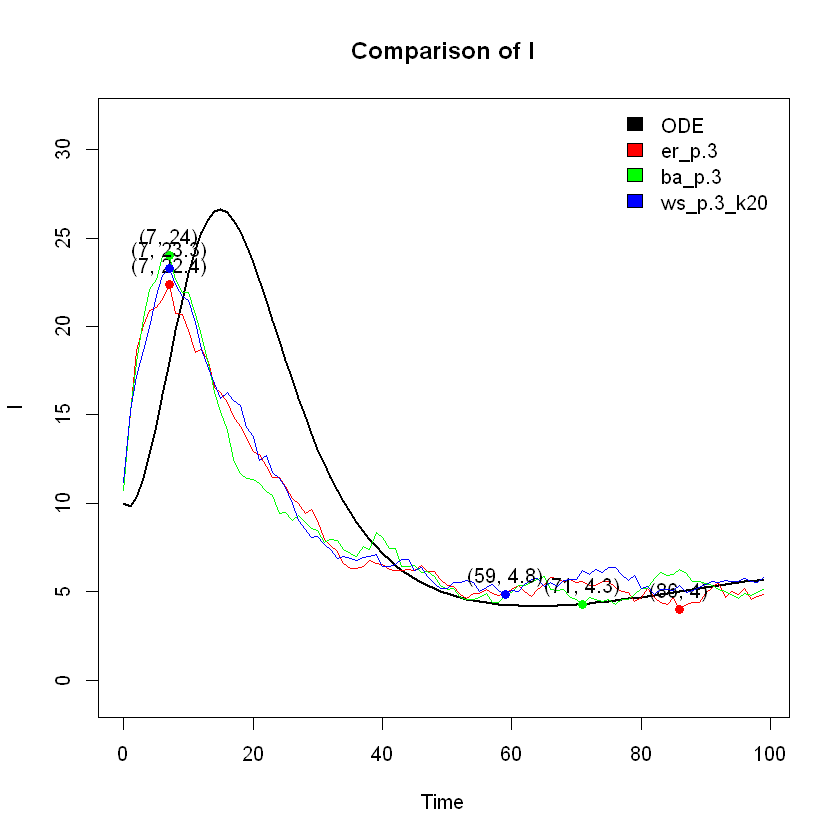

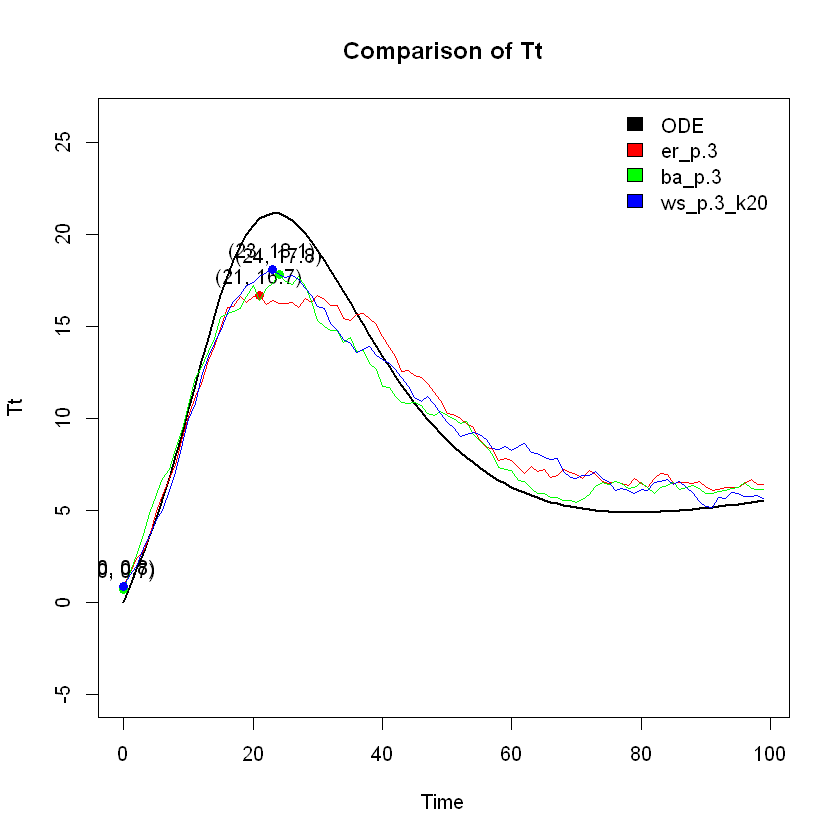

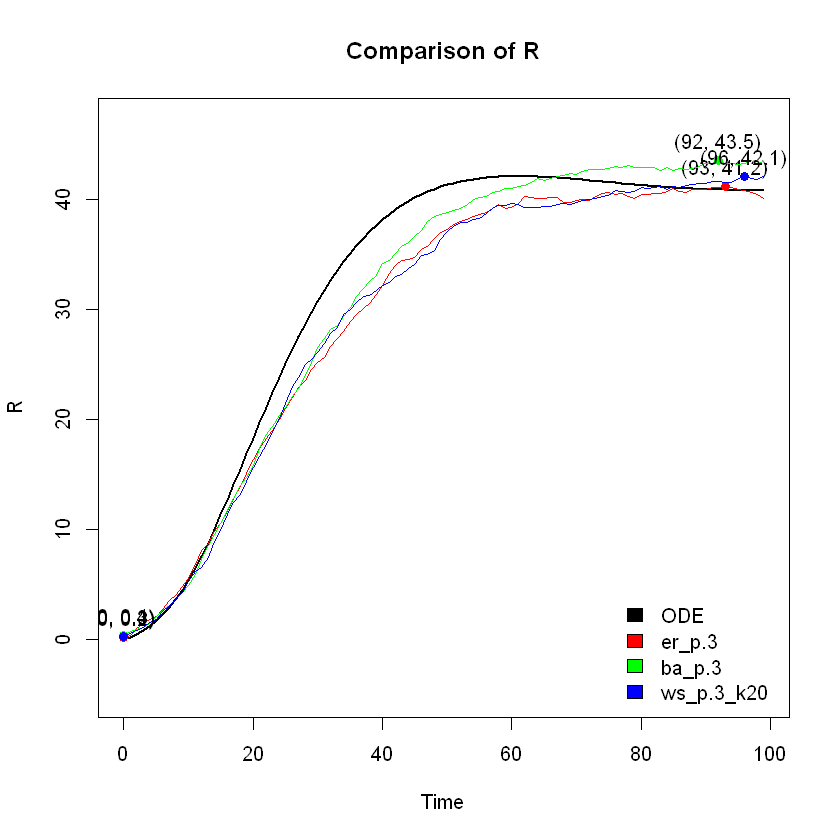

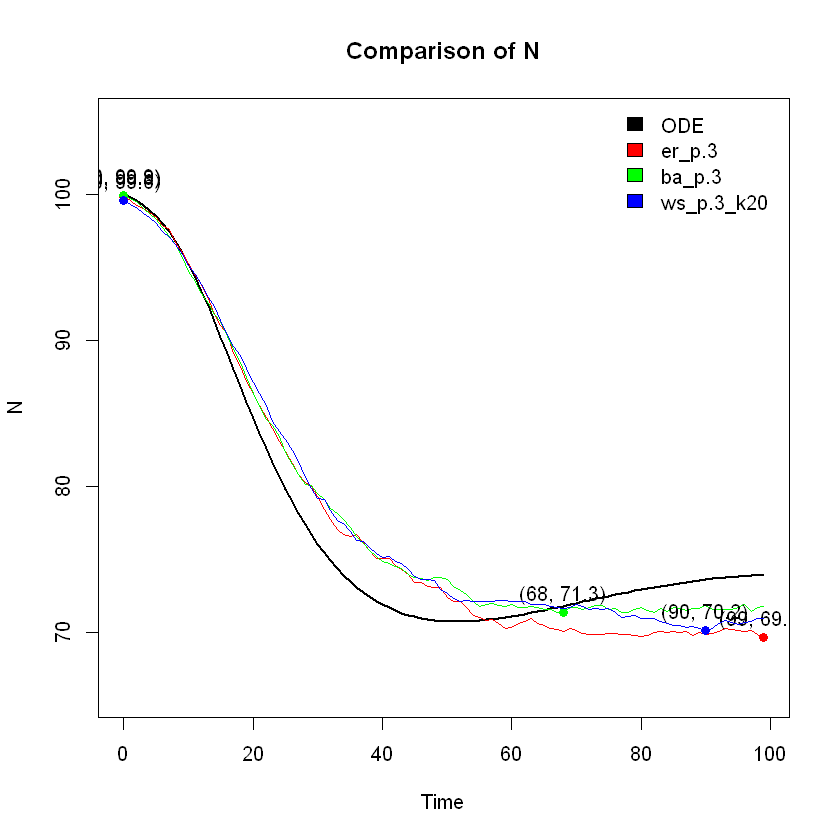

In [18]:
compare_experiment_sets(list(er_p.3, ba_p.3, ws_p.3_k20))

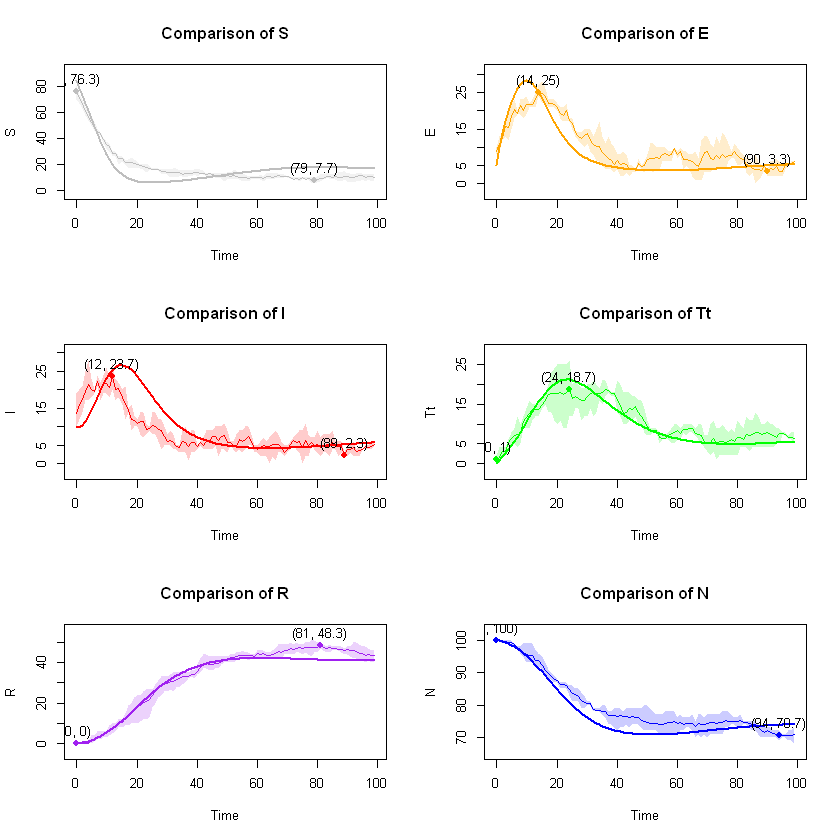

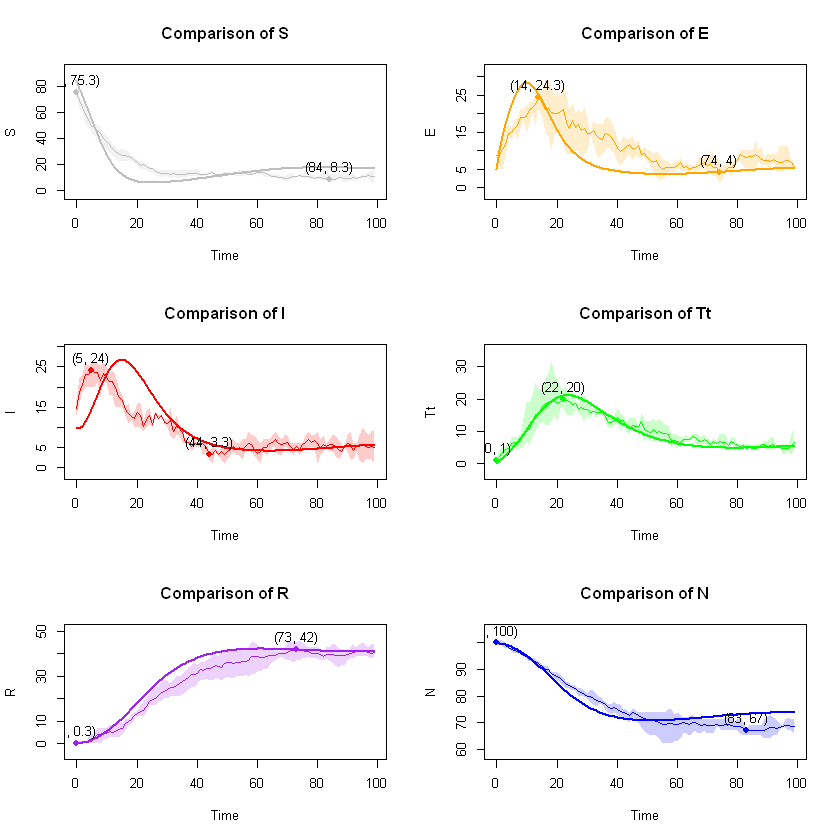

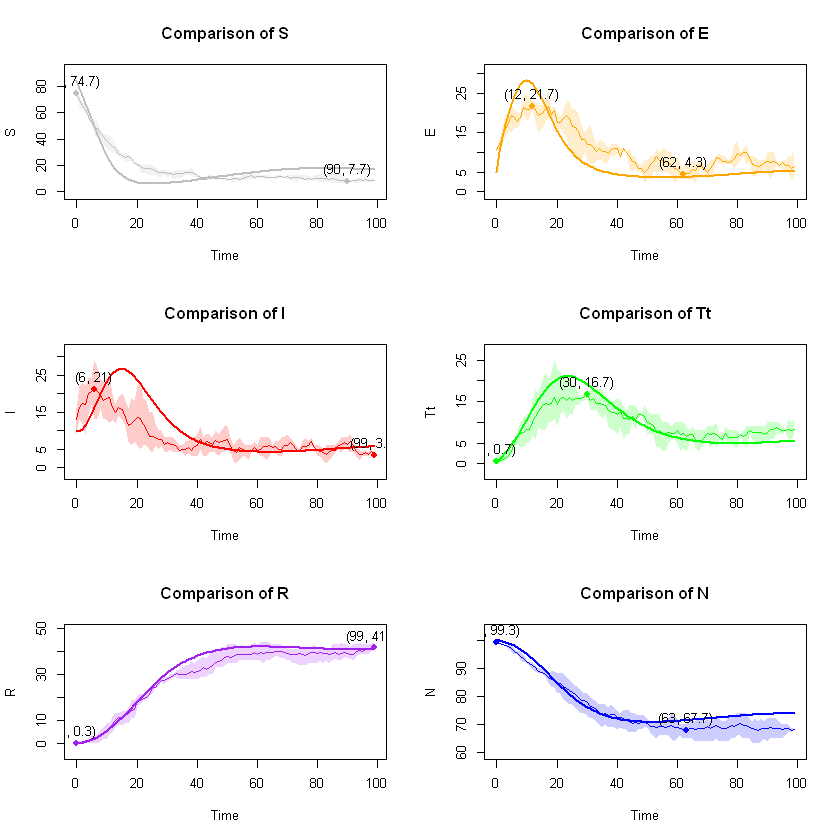

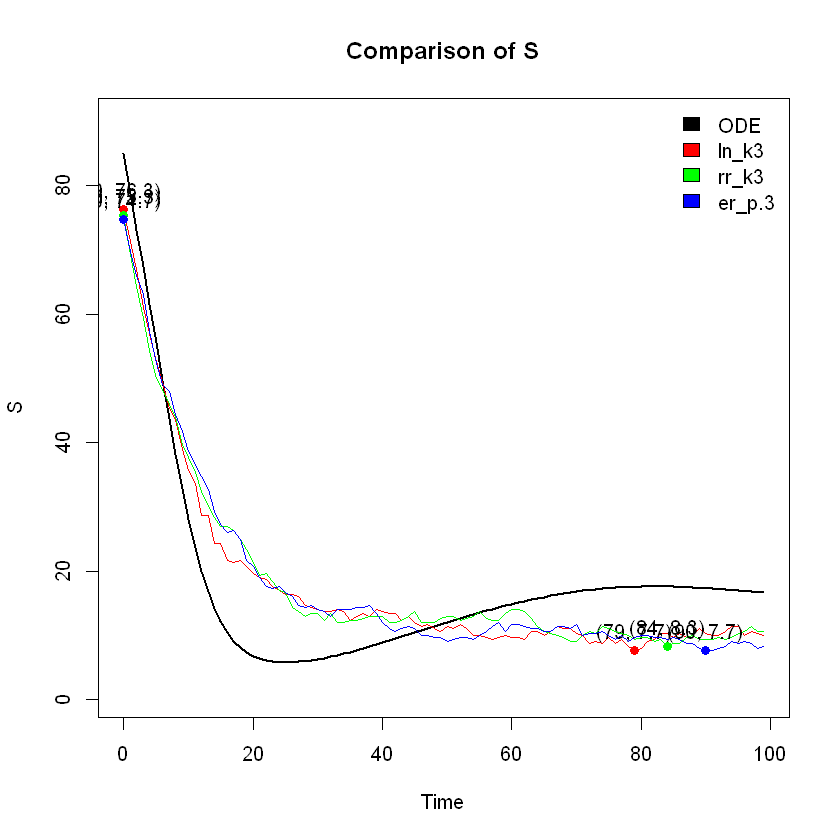

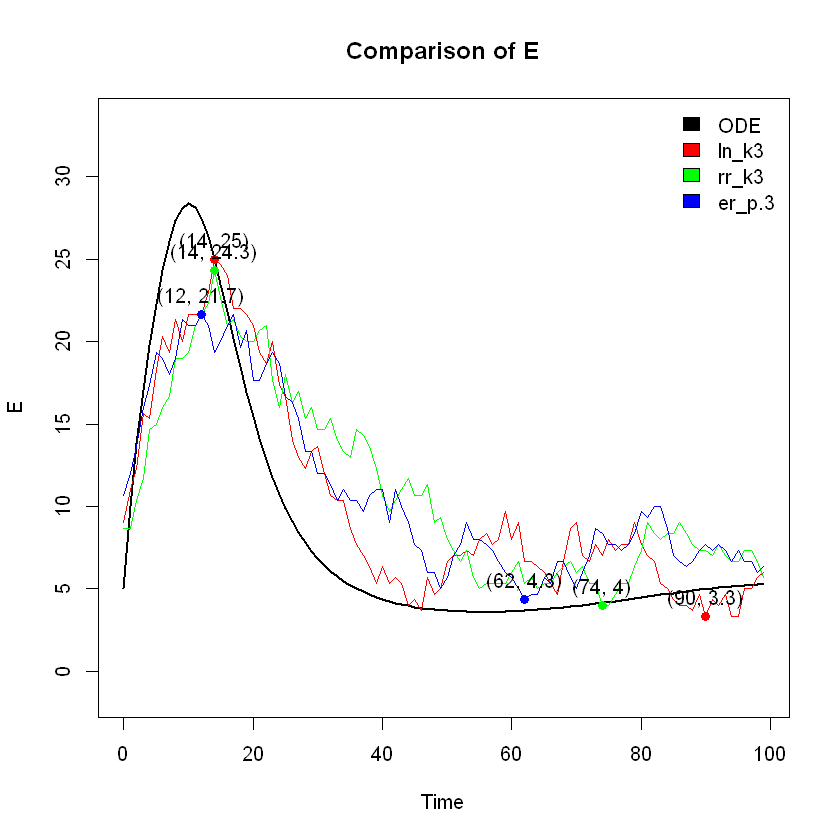

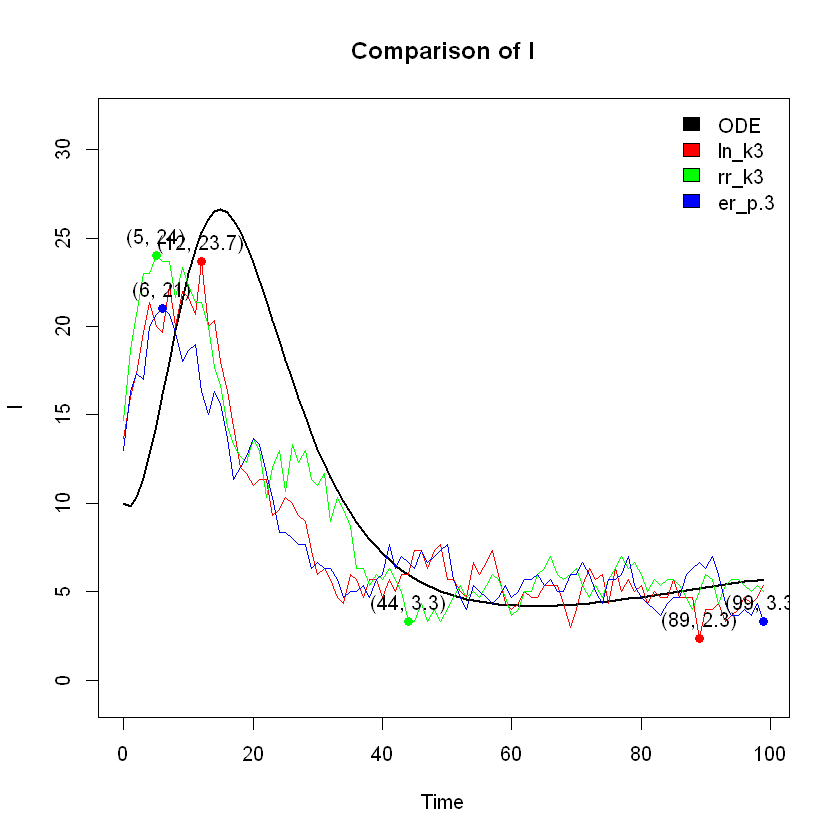

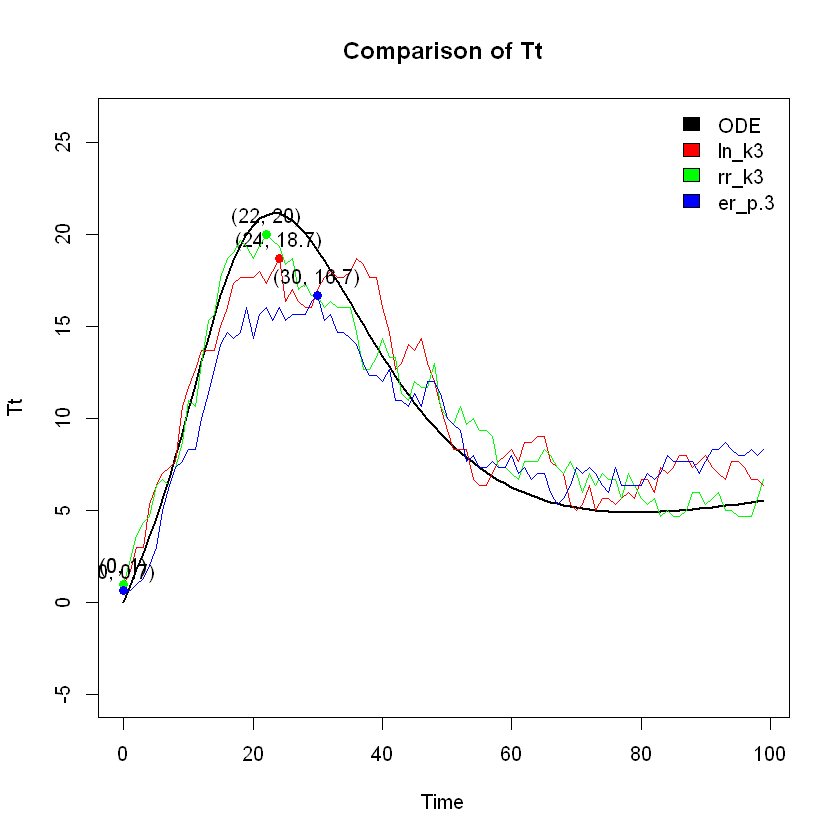

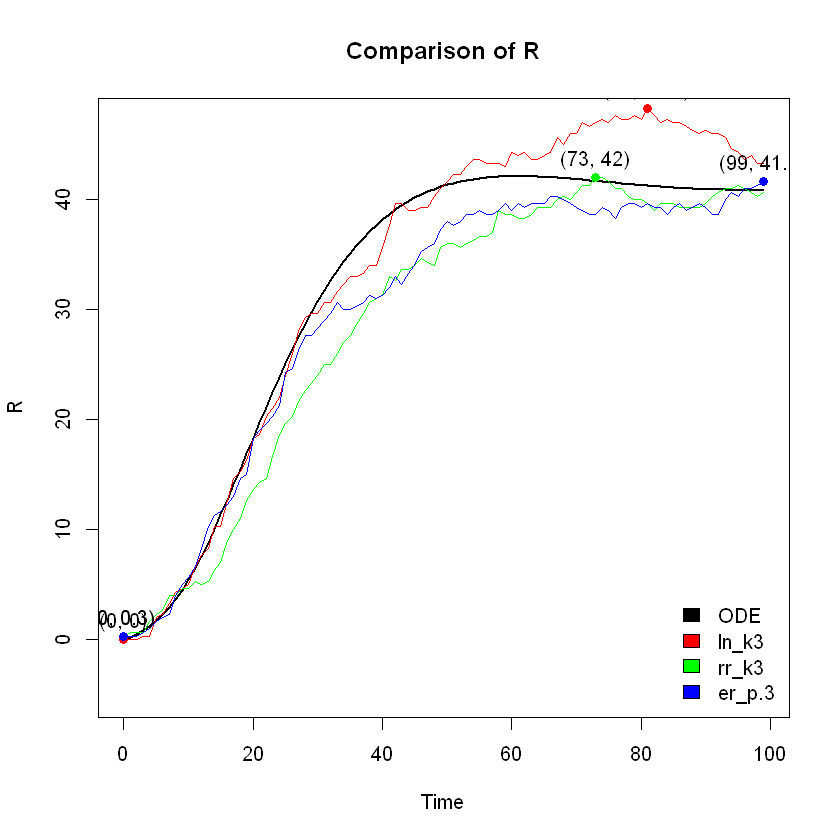

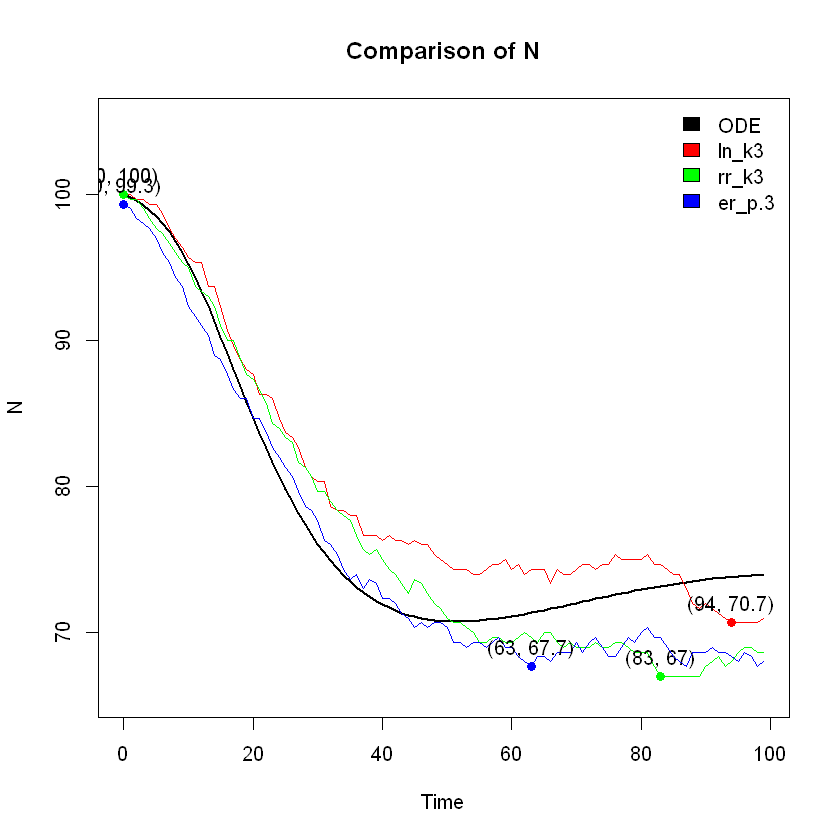

In [8]:
ln_k3 <- SEITR_network("LN", n_par1 = 3, num_exp = 3, verbose = T)
rr_k3 <- SEITR_network("RR", n_par1 = 3, num_exp = 3, verbose = T)
er_p.3 <- SEITR_network("ER", n_par1 = .3, num_exp = 3, verbose = T)
compare_experiment_sets(list(ln_k3,rr_k3, er_p.3))